In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
try:
    pio.kaleido.scope.mathjax = None
except:
    pass
import seaborn as sns
import matplotlib.pyplot as plt
import os,sys
import plotly.graph_objects as go
import sigfig
import plotly.graph_objects as go
from scipy.stats import wilcoxon

In [11]:
# set correct wd:
cwd = os.getcwd()
if not cwd.endswith('ANALYSIS'):
    os.chdir('./bin/ANALYSIS')
    sys.path.append(os.path.abspath('.'))
output_directory = '../../'
os.makedirs(f'{output_directory}/figures', exist_ok=True)

In [ ]:
# Accuracy comparison between HATCHet1, cloneHD and ALPACA
def get_hd_hatchet_alpaca_colours(palette):
    import json
    with open(palette, "r") as f:
        palette = json.load(f)
    catgorical_palette = palette["categorical"]
    colours = {}
    colours["hd"] = catgorical_palette["c12"]
    colours["hatchet"] = catgorical_palette["c8"]
    colours["alpaca"] = catgorical_palette["c2"]
    return colours


def create_consensus_segments(df1, df2,position_columns_names=['#CHR','START','END']):
    chr_colname = position_columns_names[0]
    start_colname = position_columns_names[1]
    end_colname = position_columns_names[2]
    combined = pd.concat([
        df1[[chr_colname, start_colname]].rename(columns={start_colname: "position"}),
        df1[[chr_colname, end_colname]].rename(columns={end_colname: "position"}),
        df2[[chr_colname, start_colname]].rename(columns={start_colname: "position"}),
        df2[[chr_colname, end_colname]].rename(columns={end_colname: "position"}),
    ])
    
    combined = combined.drop_duplicates().sort_values(by=[chr_colname, "position"]).reset_index(drop=True)
    
    # Create consensus segments
    consensus = combined.copy()
    consensus[end_colname] = consensus.groupby(chr_colname)["position"].shift(-1)
    consensus = consensus.dropna().rename(columns={"position": start_colname})
    consensus = consensus[[chr_colname, start_colname, end_colname]]
    
    def map_metadata(consensus, original,metadata_columns):
        consensus = consensus.copy()
        for col in metadata_columns:
            consensus[col] = None
        
        # Map metadata by checking overlaps
        for _, row in original.iterrows():
            overlap = (consensus[chr_colname] == row[chr_colname]) & \
                      (consensus[start_colname] >= row[start_colname]) & \
                      (consensus[end_colname] <= row[end_colname])
            for col in metadata_columns:
                consensus.loc[overlap, col] = row[col]
        return consensus

    metadata_columns_df1 = [col for col in df1.columns if col not in position_columns_names]
    metadata_columns_df2 = [col for col in df2.columns if col not in position_columns_names]
    consensus_df1 = map_metadata(consensus, df1,metadata_columns_df1)
    consensus_df2 = map_metadata(consensus, df2,metadata_columns_df2)
    consensus_df1 = consensus_df1.dropna()
    consensus_df2 = consensus_df2.dropna()
    
    
    consensus_df1['segment'] = consensus_df1[position_columns_names].apply(lambda x: f'{x[chr_colname]}_{int(x[start_colname])}_{int(x[end_colname])}',axis=1)
    consensus_df2['segment'] = consensus_df2[position_columns_names].apply(lambda x: f'{x[chr_colname]}_{int(x[start_colname])}_{int(x[end_colname])}',axis=1)
    
    consensus_df1['seg_len'] = consensus_df1[end_colname] - consensus_df1[start_colname]
    consensus_df2['seg_len'] = consensus_df2[end_colname] - consensus_df2[start_colname]
    
    # remove zero-length segments:
    consensus_df1 = consensus_df1[consensus_df1['seg_len'] > 0]
    consensus_df2 = consensus_df2[consensus_df2['seg_len'] > 0]
    
    # keep only common segments:
    common_segments = set(consensus_df1['segment']).intersection(set(consensus_df2['segment']))
    consensus_df1 = consensus_df1[consensus_df1['segment'].isin(common_segments)]
    consensus_df2 = consensus_df2[consensus_df2['segment'].isin(common_segments)]
    assert consensus_df1.shape[0] == consensus_df2.shape[0]
    return consensus_df1, consensus_df2


def get_score_for_segment(segment_df_true,segment_df_model,clone_columns_true,clone_columns_model):
    set_of_predicted_cns = set(sum([x.split('|') for x in segment_df_model[clone_columns_model].values[0]],[]))
    set_of_true_cns = set(sum([x.split('|') for x in segment_df_true[clone_columns_true].values[0]],[]))
    assert len(set_of_predicted_cns) > 0
    assert len(set_of_true_cns) > 0
    seg_len = segment_df_true['seg_len'].values[0]
    recovered = len(set_of_predicted_cns.intersection(set_of_true_cns))
    all_states = len(set_of_predicted_cns.union(set_of_true_cns))
    predicted_denom = len(set_of_predicted_cns)
    true_denom = len(set_of_true_cns)
    precision = seg_len * (recovered / predicted_denom)
    recall = seg_len * (recovered / true_denom)
    accuracy = seg_len * (recovered / all_states)
    return precision, recall, accuracy


def get_metrics_per_case(model_consensus,TRUE_consensus,clone_columns_true,clone_columns_model):
    precision_list = []
    recall_list = []
    accuracy_list = []
    for segment in model_consensus['segment']:
        segment_df_model = model_consensus[model_consensus['segment']==segment]
        segment_df_true = TRUE_consensus[TRUE_consensus['segment']==segment]
        precision,recall,accuracy = get_score_for_segment(segment_df_true,segment_df_model,clone_columns_true,clone_columns_model)
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
    total_len = sum(model_consensus['seg_len'])
    precision = sum(precision_list)/total_len
    recall = sum(recall_list)/total_len
    accuracy = sum(accuracy_list)/total_len
    return precision,recall,accuracy


def load_H1_results(dataset_name,experiment,hatchet1_output_dir):
    wgd_results_path = f'{hatchet1_output_dir}/WGD/{dataset_name}/{experiment}/hatchet/hatchet.seg.ucn.gz'
    nowgd_results_path = f'{hatchet1_output_dir}/noWGD/{dataset_name}/{experiment}/hatchet/hatchet.seg.ucn.gz'
    if os.path.exists(wgd_results_path):
        H1_results = pd.read_csv(wgd_results_path, sep='\t')
    else:
        H1_results = pd.read_csv(nowgd_results_path, sep='\t')
    H1_results['#CHR'] = H1_results['#CHR'].apply(lambda x: x.replace('chr',''))
    H1_results['START'] = H1_results['START'].astype(int)
    H1_results['END'] = H1_results['END'].astype(int)
    H1_results.rename(columns={'cn_normal':'cn_clone100'},inplace=True)
    position_columns_names=['#CHR','START','END']
    H1_results_clones = [x for x in H1_results.columns if x.startswith('cn_')]
    H1_results = H1_results[position_columns_names + H1_results_clones].drop_duplicates() 
    return H1_results


def load_clone_HD_results(dataset_name,experiment,hatchet1_output_dir):
    wgd_results_path = f'{hatchet1_output_dir}/WGD/{dataset_name}/{experiment}/clonehd/cloneHD.BEST.results.gz'
    nowgd_results_path = f'{hatchet1_output_dir}/noWGD/{dataset_name}/{experiment}/clonehd/cloneHD.BEST.results.gz'
    if os.path.exists(wgd_results_path):
        clone_hd_results = pd.read_csv(wgd_results_path, sep='\t')
    else:
        clone_hd_results = pd.read_csv(nowgd_results_path, sep='\t')
    # fix column names:
    clone_hd_results.rename(columns={'END':'SAMPLE','SAMPLE':'END'},inplace=True)
    assert clone_hd_results['END'].dtype.type == np.int64
    assert clone_hd_results['SAMPLE'].dtype.type == np.object_
    
    clone_hd_results['#CHR'] = clone_hd_results['#CHR'].apply(lambda x: x.replace('chr',''))
    clone_hd_results['START'] = clone_hd_results['START'].astype(int)
    clone_hd_results['END'] = clone_hd_results['END'].astype(int)
    clone_hd_results.rename(columns={'cn_normal':'cn_clone100'},inplace=True)
    position_columns_names=['#CHR','START','END']
    clone_hd_results_clones = [x for x in clone_hd_results.columns if x.startswith('cn_')]
    clone_hd_results = clone_hd_results[position_columns_names + clone_hd_results_clones].drop_duplicates() 
    return clone_hd_results


def load_alpaca_hatchet_format(alpaca_output_dir,tumour_id):
    alpaca_results = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv')[['clone','pred_CN_A','pred_CN_B','segment']]
    normal_clones = ['diploid']
    alpaca_results = alpaca_results[~alpaca_results.clone.isin(normal_clones)]
    alpaca_results['cn'] = alpaca_results[['pred_CN_A','pred_CN_B']].apply(lambda x: f'{x[0]}|{x[1]}',axis=1)
    alpaca_results.drop(['pred_CN_A','pred_CN_B'],axis=1,inplace=True)
    # to wide format:
    alpaca_results_wide = alpaca_results.pivot(index='segment',columns='clone',values='cn').reset_index()
    alpaca_results_wide['#CHR'] = alpaca_results_wide['segment'].apply(lambda x: x.split('_')[0])
    alpaca_results_wide['START'] = alpaca_results_wide['segment'].apply(lambda x: int(x.split('_')[1]))
    alpaca_results_wide['END'] = alpaca_results_wide['segment'].apply(lambda x: int(x.split('_')[2]))
    alpaca_results_wide.drop(['segment'],axis=1,inplace=True)
    return alpaca_results_wide


def load_true_copynumber_states(hatchet_sim_true_cns,h2_name_no_suffix):
    true_copynumber_states_nowgd_path = f'{hatchet_sim_true_cns}/noWGD/{h2_name_no_suffix}/tumor/copynumbers.csv'
    true_copynumber_states_wgd_path = f'{hatchet_sim_true_cns}/WGD/{h2_name_no_suffix}/tumor/copynumbers.csv'
    true_copynumber_states = pd.read_table(true_copynumber_states_nowgd_path, sep='\t') if os.path.exists(true_copynumber_states_nowgd_path) else pd.read_csv(true_copynumber_states_wgd_path, sep='\t')
    true_copynumber_states['#CHR'] = true_copynumber_states['#CHR'].apply(lambda x: x.replace('chr',''))
    true_copynumber_states['START'] = true_copynumber_states['START'].astype(int)
    true_copynumber_states['END'] = true_copynumber_states['END'].astype(int)
    true_copynumber_states['clone100'] = '1|1'
    return true_copynumber_states


def get_model_metrics(model_results, true_copynumber_states):
    MODEL_consensus,TRUE_consensus = create_consensus_segments(model_results, true_copynumber_states)
    clone_columns_model = [x for x in MODEL_consensus.columns if 'clone' in x]
    if len(clone_columns_model) == 0:
        clone_columns_model = [x for x in MODEL_consensus.columns if 'cn_' in x]
    clone_columns_true = [x for x in TRUE_consensus.columns if 'clone' in x]
    precision,recall,accuracy = get_metrics_per_case(MODEL_consensus,TRUE_consensus,clone_columns_true,clone_columns_model,)
    return {'precision':precision,'recall':recall,'accuracy':accuracy}


def make_plot(results_H1_df=pd.Series(),results_ALPACA_df=pd.Series(),results_cloneHD_df=pd.Series(),colours={},metric='accuracy', font_size=45,w=600,h=800,fonts='Arial'):
    y_axis_title = metric.capitalize()


    fig = go.Figure()
    fig.update_layout(title='', font=dict(family=fonts, size=font_size), width=w, height=h, showlegend=False, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='black', zeroline=True, zerolinecolor='black', zerolinewidth=1, title=y_axis_title, title_font=dict(family=fonts, size=font_size*0.8),)
    jitter_value = 0.5
    point_size = font_size/10
    line_width = 2
    if len(colours) == 0:
        hatchet_colour = 'blue'
        alpaca_colour = 'orange'
        clonehd_colour = 'green'
    else:
        alpaca_colour = colours['alpaca']
        hatchet_colour = colours['hatchet']
        clonehd_colour = colours['hd']
    
    if len(results_cloneHD_df)>0:
        cloneHD_trace = go.Box(y=results_cloneHD_df[metric], orientation='v', boxpoints='all', jitter=jitter_value, pointpos=0, line=dict(color=clonehd_colour, width=line_width), marker=dict(size=point_size),name='cloneHD')
        fig.add_trace(cloneHD_trace)
        
    if len(results_H1_df)>0:
        hatchet1_trace = go.Box(y=results_H1_df[metric], orientation='v', boxpoints='all', jitter=jitter_value, pointpos=0, line=dict(color=hatchet_colour, width=line_width), marker=dict(size=point_size), name='HATCHet')
        fig.add_trace(hatchet1_trace)
    
    if len(results_ALPACA_df)>0:
        alpaca_trace = go.Box(y=results_ALPACA_df[metric], orientation='v', boxpoints='all', jitter=jitter_value, pointpos=0, line=dict(color=alpaca_colour, width=line_width), marker=dict(size=point_size),name='ALPACA')
        fig.add_trace(alpaca_trace)
    
    fig.update_layout(
        font=dict(family=fonts, size=font_size),
        width=w, height=h,
        paper_bgcolor='white',
        plot_bgcolor='white'
        )
    return fig


def add_p_value_annotation(fig, pvals, _format=dict(interline=0.07, text_height=1.07, color='black'),gap_offset = 0.025, row_offset= 0.05, pvals_type = 'numbers',annotation_font_size=12,add_brackets=True):    
    y_loc = 1
    for box_pair in pvals.keys():
        # add horizontal line:
        pvalue = pvals[box_pair]
        
        if pvals_type == 'numbers':
            if pvalue < 0.001:
                formatted = sigfig.round(pvalue, sigfigs=3, notation='scientific')
                base, exponent = formatted.split('E')
                symbol = f"P = {base}×10<sup>{int(exponent)}</sup>"
            else:
                symbol = f"P = {sigfig.round(pvalue, sigfigs=3)}"                
        elif pvals_type == 'stars':
            if pvalue >= 0.05:
                symbol = 'ns'
            elif pvalue >= 0.01: 
                symbol = '*'
            elif pvalue >= 0.001:
                symbol = '**'
            else:
                symbol = '***'
        if add_brackets:                
            fig.add_shape(type="line",
                        xref="x", yref="y domain",
                        x0=box_pair[0], y0=y_loc, 
                        x1=box_pair[1], y1=y_loc,
                        line=dict(color=_format['color'], width=2,)
                    )
            # Vertical line
            fig.add_shape(type="line",
                xref="x", yref="y domain",
                x0=box_pair[0], y0=y_loc, 
                x1=box_pair[0], y1=y_loc-0.025,
                line=dict(color=_format['color'], width=2,)
            )
            # Vertical line
            fig.add_shape(type="line",
                xref="x", yref="y domain",
                x0=box_pair[1], y0=y_loc, 
                x1=box_pair[1], y1=y_loc-0.025,
                line=dict(color=_format['color'], width=2,)
        )

        annotation_x = (box_pair[0] + box_pair[1])/2
        annotation_y = y_loc + gap_offset
        fig.add_annotation(dict(font=dict(color=_format['color'],size=annotation_font_size),
            x=annotation_x,
            y=annotation_y,
            showarrow=False,
            text=symbol,
            textangle=0,
            xref="x",
            yref="y domain"
        ))
        y_loc += row_offset
    return fig


def wilcoxon_test(list_of_series):
    results = {}
    for i in range(len(list_of_series)):
        for j in range(i + 1, len(list_of_series)):
            col1 = list_of_series[i]
            col2 = list_of_series[j]
            t_stat, p_value = wilcoxon(col1, col2)
            results[(i, j)] = p_value
    return results


def get_H2_alpaca_name_mapping(H2_output_dir):
    datasets_original_names = [x for x in os.listdir(H2_output_dir) if 'dataset' in x]
    formatted_names = {}
    for h2_dataset in datasets_original_names:
        file_path = f'{H2_output_dir}/{h2_dataset}/hatchet.ini'
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('bam'):
                    bam_line = line
                    break
        # find experiment name:
        bam_line_split = bam_line.split('/')
        h2_dataset_without_suffix = '_'.join(h2_dataset.split('_')[:3])
        dataset_index = bam_line_split.index(h2_dataset_without_suffix)
        experiment_name = bam_line_split[dataset_index+1]
        dataset_name_formatted = h2_dataset_without_suffix.replace('_','-')
        experiment_name_formatted = experiment_name.replace('_','-')
        formatted_names[h2_dataset] = f'{dataset_name_formatted}.{experiment_name_formatted}'
    return formatted_names
    
    
def load_H2_results(h2_name,hatchet2_output_dir):
    H2_results = pd.read_csv(f'{hatchet2_output_dir}/{h2_name}/results/best.seg.ucn', sep='\t')
    H2_results['#CHR'] = H2_results['#CHR'].apply(lambda x: x.replace('chr',''))
    H2_results['START'] = H2_results['START'].astype(int)
    H2_results['END'] = H2_results['END'].astype(int)
    H2_results.rename(columns={'cn_normal':'cn_clone100'},inplace=True)
    position_columns_names=['#CHR','START','END']
    H2_results_clones = [x for x in H2_results.columns if x.startswith('cn_')]
    H2_results = H2_results[position_columns_names + H2_results_clones].drop_duplicates() 
    return H2_results



cohort = 'mascote'
run_name='mascote_default'
os.chdir(f'../..')
processed_files_path = f'temp/alpaca_H2_cloneHD_mascote'
os.makedirs(processed_files_path, exist_ok=True)

hatchet_sim_true_cns = f'_assets/hatchet-paper/simulation/data'
alpaca_output_dir = f'output/{cohort}/{run_name}'
hatchet1_output_dir_h1_repo = f'_assets/hatchet-paper/simulation/free/'
hatchet1_sim_input = f'_assets/hatchet-paper/simulation/data'
hatchet2_output_dir = f'_assets/hatchet2'
H2_alpaca_mapping = get_H2_alpaca_name_mapping(hatchet2_output_dir)
colours_path = f'_assets/publication_palette.json'
colours = get_hd_hatchet_alpaca_colours(colours_path)

results = {}
results['results_H1'] = {}
results['results_ALPACA'] = {}
results['results_cloneHD'] = {}
results['results_H2'] = {}
tumour_ids = [x for x in os.listdir(f'{alpaca_output_dir}/patient_outputs') if 'dataset' in x]
for tumour_id in tumour_ids:
    dataset_name = tumour_id.split('.')[0].replace('-','_')
    experiment = tumour_id.split('.')[1].replace('-','_')
    alpaca_results = load_alpaca_hatchet_format(alpaca_output_dir,tumour_id)
    true_copynumber_states = load_true_copynumber_states(hatchet1_sim_input,dataset_name)
    H1_results = load_H1_results(dataset_name,experiment,hatchet1_output_dir_h1_repo)
    clone_HD_results = load_clone_HD_results(dataset_name,experiment,hatchet1_output_dir_h1_repo)
    results['results_ALPACA'][tumour_id] = get_model_metrics(alpaca_results, true_copynumber_states)
    results['results_H1'][tumour_id] = get_model_metrics(H1_results, true_copynumber_states)
    results['results_cloneHD'][tumour_id] = get_model_metrics(clone_HD_results, true_copynumber_states)
    if tumour_id in list(H2_alpaca_mapping.values()):
        results['results_ALPACA'][tumour_id] = get_model_metrics(alpaca_results, true_copynumber_states)
        reverse_dict = {v: k for k, v in H2_alpaca_mapping.items()}
        h2_name = reverse_dict[tumour_id]
        h2_name_no_suffix = '_'.join(h2_name.split('_')[:3])
        H2_results = load_H2_results(h2_name,hatchet2_output_dir)
        results['results_H2'][tumour_id] = get_model_metrics(H2_results, true_copynumber_states)
    
results_df_H1 = pd.DataFrame(results['results_H1']).T
results_df_ALPACA = pd.DataFrame(results['results_ALPACA']).T
results_df_cloneHD = pd.DataFrame(results['results_cloneHD']).T  

w=200
h=600
lables_font_size=25
annotation_font_size=24
metric='accuracy'
paired_p_vals = wilcoxon_test([results_df_cloneHD[metric],results_df_H1[metric],results_df_ALPACA[metric]])
print(metric)
print(paired_p_vals)
fig = make_plot(results_H1_df=results_df_H1,
                results_ALPACA_df=results_df_ALPACA,
                results_cloneHD_df=results_df_cloneHD,
                colours=colours,
                )
add_p_value_annotation(fig, paired_p_vals,gap_offset = 0.06, row_offset= 0.09,annotation_font_size=annotation_font_size)
fig.update_layout(
    margin=dict(l=0, r=0, t=130, b=0),
)
fig.show()
fig.write_image(f'figures/Fig1b_accuracy_comparison_boxplot.pdf')
os.chdir(f'bin/ANALYSIS')

accuracy
{(0, 1): np.float64(1.7981591168806198e-06), (0, 2): np.float64(5.208452253035007e-10), (1, 2): np.float64(0.0010747534600181409)}


In [63]:
# Figure 1: Describe simulated cohort:
simulation_cohort = 'simulations'
simulation_run = 'simulations_default'
simulations_results = pd.read_csv(f'{output_directory}/output/{simulation_cohort}/{simulation_run}/cohort_outputs/combined.csv')
simulations_results = simulations_results[simulations_results.clone!='diploid']
unique_tumours = len(simulations_results.tumour_id.unique())
unique_clones = len(simulations_results[['tumour_id','clone']].drop_duplicates())
unique_segments = len(simulations_results[['tumour_id','segment']].drop_duplicates())
unique_clone_and_allele_specific_segments = len(simulations_results[['tumour_id','clone','segment']].drop_duplicates()) * 2 # double to account for both alleles
print(f'Number of simulated tumours: {unique_tumours}')
print(f'Number of simulated clones: {unique_clones}')
print(f'Number of simulated segments: {unique_segments}')
print(f'Number of clone- and allele-specific segments: {unique_clone_and_allele_specific_segments}')

Number of simulated tumours: 148
Number of simulated clones: 2651
Number of simulated segments: 86282
Number of clone- and allele-specific segments: 3122888


In [74]:
[ y for y in list(int(x) for x in simulations_results['tumour_id'].str.replace('LTXSIM','').astype(int).sort_values(ascending=True).unique()) if y not in list(range(1,151))] # check if all tumours are present

[]

In [64]:
# Figure 1: Sankey plot for simulated cohort
from SIMULATIONS_sankey_plot import *
scores_all_tumours = f'{output_directory}/output/{simulation_cohort}/{simulation_run}/cohort_outputs/scores/scores_all_tumours.csv'
scores_all_tumours = pd.read_csv(scores_all_tumours)
scores_all_tumours = scores_all_tumours[['clone','allele','segment','tumour_id','cn_true','cn_alpaca','correct']].drop_duplicates()
scores_all_tumours.cn_alpaca.clip(upper=5,inplace=True)
sankey = plotFlowDiagram(scores_all_tumours,'',hide_labels=True)
sankey.write_image(f'{output_directory}/figures/Fig1c_simulations_sankey.pdf')
sankey.show()
print('Fraction of clone- and allele-specific segments assigned correct copy number:')
print(round(scores_all_tumours.correct.sum()/len(scores_all_tumours),3))
print('Fraction of clone- and allele-specific segments assigned correct copy number:')
print(str(scores_all_tumours.correct.sum())+"/"+str(len(scores_all_tumours)))

Fraction of clone- and allele-specific segments assigned correct copy number:
0.988
Fraction of clone- and allele-specific segments assigned correct copy number:
3086744/3122888


In [7]:
# Sankey plot labels:
# labels for illustrator:
zero = f' Zero predicted as zero {((scores_all_tumours.cn_alpaca == 0) & (scores_all_tumours.cn_true == 0)).sum()}'
one = f' One predicted as one {((scores_all_tumours.cn_alpaca == 1 )& (scores_all_tumours.cn_true == 1)).sum()}'
two = f' Two predicted as two {((scores_all_tumours.cn_alpaca == 2) & (scores_all_tumours.cn_true == 2)).sum()}'
three = f' Three predicted as three {((scores_all_tumours.cn_alpaca == 3) & (scores_all_tumours.cn_true == 3)).sum()}'
four = f' Four predicted as four {((scores_all_tumours.cn_alpaca == 4) & (scores_all_tumours.cn_true == 4)).sum()}'
# labels for illustrator - fractions:
zero_fr = f' Zero predicted as zero {((scores_all_tumours.cn_alpaca == 0) & (scores_all_tumours.cn_true == 0)).sum()/(scores_all_tumours.cn_true == 0).sum()}'
one_fr = f' One predicted as one {((scores_all_tumours.cn_alpaca == 1 )& (scores_all_tumours.cn_true == 1)).sum()/(scores_all_tumours.cn_true == 1).sum()}'
two_fr = f' Two predicted as two {((scores_all_tumours.cn_alpaca == 2) & (scores_all_tumours.cn_true == 2)).sum()/(scores_all_tumours.cn_true == 2).sum()}'
three_fr = f' Three predicted as three {((scores_all_tumours.cn_alpaca == 3) & (scores_all_tumours.cn_true == 3)).sum()/(scores_all_tumours.cn_true == 3).sum()}'
four_fr = f' Four predicted as four {((scores_all_tumours.cn_alpaca == 4) & (scores_all_tumours.cn_true == 4)).sum()/(scores_all_tumours.cn_true == 4).sum()}'
with open(f'{output_directory}/figures/Fig1e_sankey_plot_publication_metrics.txt','w') as f:
    f.write('labels for illustrator:'+'\n')
    f.write('zero as zero: '+zero+'\n')
    f.write('one as one: '+one+'\n')
    f.write('two as two: '+two+'\n')
    f.write('three as three: '+three+'\n')
    f.write('four as four: '+four+'\n')
    f.write('labels for illustrator - fractions:'+'\n')
    f.write('zero as zero: '+zero_fr+'\n')
    f.write('one as one: '+one_fr+'\n')
    f.write('two as two: '+two_fr+'\n')
    f.write('three as three: '+three_fr+'\n')
    f.write('four as four: '+four_fr+'\n')

In [ ]:
# HATCHET2+MEDICC2 vs ALPACA on simulations
import pandas as pd
import json
import os
import plotly.express as px
import plotly.graph_objects as go
from functions import cast_HATCHET_to_ALPACA,compare_copynumber_profiles,cast_MEDICC_to_ALPACA,get_proportions_whole_tumour,get_HATCHET_proportions
from metrics_functions import get_distance_metrics,get_comparison_dfs

mount_point='../..'
overwrite = False
hatchet_output = f'{mount_point}/_assets/benchmarking/tx421sims'
alpaca_input_dir = f'{mount_point}/_assets/benchmarking/simulations/alpaca_input/'
alpaca_output_dir = f'{mount_point}/_assets/benchmarking/simulations/alpaca_output/'
simulations_input_path = f'{mount_point}/_assets/benchmarking/tx_analysis'
true_tree_simulations = f'{mount_point}/_assets/benchmarking/simulations'
processed_files_path = f'{mount_point}/_assets/benchmarking/H2_alpaca_comparison/data'
os.makedirs(processed_files_path, exist_ok=True)
tumour_ids = [ x for x in os.listdir(alpaca_input_dir) if 'LTX' in x]
all_tumour_results = []
for tumour_id in tumour_ids:
    results_dict = {}
    processed_output_name = f'{processed_files_path}/{tumour_id}_matching_comparison.csv'
    tumour_dir = f'{hatchet_output}/{tumour_id}'
    medicc_dir = f'{tumour_dir}/medicc'
    if os.path.exists(processed_output_name) and not overwrite:
        results_df = pd.read_csv(processed_output_name)
        all_tumour_results.append(results_df)
    else:
        ALPACA_input = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/ALPACA_input_table.csv')
        ALPACA_output = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv').drop_duplicates()
        ALPACA_output = ALPACA_output[ALPACA_output.clone!='diploid']
        # Use medicc output instead:
        comparator_name = 'MEDICC2'
        if comparator_name == 'MEDICC2':
            MEDICC_output_raw_path = f'{medicc_dir}/{tumour_id}_final_cn_profiles.tsv'
            if not os.path.exists(MEDICC_output_raw_path):
                continue
            MEDICC_output_raw = pd.read_table(MEDICC_output_raw_path)
            MEDICC_output = cast_MEDICC_to_ALPACA(MEDICC_output_raw)
            # hatchet or meddic:
            COMPARATOR_output = MEDICC_output
        else:
            HATCHET_output_raw = pd.read_csv(f'{hatchet_output}/{tumour_id}/results/best.seg.ucn', sep='\t')
            HATCHET_output = cast_HATCHET_to_ALPACA(HATCHET_output_raw)
            COMPARATOR_output = HATCHET_output
        COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['clone']!='diploid']
        TRUE_copynumbers = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/copynumbers.csv')
        patient_output_path =  f'{alpaca_output_dir}/patient_outputs/{tumour_id}/'
        simulations_path = f'{simulations_input_path}/{tumour_id}/sim'
        true_props_path =  f'{simulations_path}/{tumour_id}_cloneprops.tsv'
        conipher_props_path = f'{alpaca_input_dir}/{tumour_id}/cp_table.csv'
        common_segments = set.intersection(set(COMPARATOR_output['segment']), set(ALPACA_output['segment']), set(TRUE_copynumbers['segment']))
        TRUE_copynumbers = TRUE_copynumbers[TRUE_copynumbers['segment'].isin(common_segments)]
        ALPACA_output = ALPACA_output[ALPACA_output['segment'].isin(common_segments)]
        COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['segment'].isin(common_segments)]
        alpaca_score = compare_copynumber_profiles(TRUE_copynumbers,ALPACA_output,metric='hamming')['closest_clone_distance'].mean()
        comparator_score = compare_copynumber_profiles(TRUE_copynumbers,COMPARATOR_output,metric='hamming')['closest_clone_distance'].mean()
        results_dict[tumour_id] = {'alpaca_score':alpaca_score, f'{comparator_name}':comparator_score}
        results_df = pd.DataFrame(results_dict).T.reset_index()
        results_df.to_csv(processed_output_name,index=False)
        all_tumour_results.append(results_df)
matching_distance_results = pd.concat(all_tumour_results)

In [14]:
# TVD
verbose=False
all_results=[]
for tumour_id in tumour_ids:
    results_tumour_path = f'{processed_files_path}/{tumour_id}_distance_metrics.csv'
    if os.path.exists(results_tumour_path):
        results_tumour = pd.read_csv(results_tumour_path)
        all_results.append(results_tumour)
        continue
    results_tumour = []
    TRUE_copynumbers = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/copynumbers.csv')
    TRUE_proportions = get_proportions_whole_tumour(pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/true_proportions.csv'))
    TRUE_proportions['clone'] = 'clone'+TRUE_proportions['clone'].astype(str) if 'clone' not in str(TRUE_proportions.clone.iloc[0]) else TRUE_proportions['clone']
    ALPACA_output = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv').drop_duplicates()
    ALPACA_output = ALPACA_output[ALPACA_output.clone!='diploid']
    CONIPHER_proportions = get_proportions_whole_tumour(pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/cp_table.csv'))
    HATCHET_output_raw = pd.read_csv(f'{hatchet_output}/{tumour_id}/results/best.seg.ucn', sep='\t')
    HATCHET_output = cast_HATCHET_to_ALPACA(HATCHET_output_raw)
    HATCHET_proportions = get_HATCHET_proportions(HATCHET_output_raw)
    segments = TRUE_copynumbers['segment'].unique()
    for seg_ind,segment in enumerate(segments):
        print(f'{tumour_id} segment {segment} {seg_ind+1}/{len(segments)}') if verbose else None
        true_copynumbers_seg = TRUE_copynumbers.query('segment == @segment')
        alpaca_segment = ALPACA_output.query('segment == @segment')
        hatchet_segment = HATCHET_output.query('segment == @segment')
        #calculate scores for alpaca
        comparison_df_A,comparison_df_B = get_comparison_dfs(true_copynumbers_seg,TRUE_proportions,alpaca_segment,CONIPHER_proportions)
        output_df_alpaca = get_distance_metrics(comparison_df_A,comparison_df_B,tumour_id,segment)
        output_df_alpaca['model'] = 'ALPACA'
        #calculate scores for hatchet
        comparison_df_A,comparison_df_B = get_comparison_dfs(true_copynumbers_seg,TRUE_proportions,hatchet_segment,HATCHET_proportions)
        output_df_hatchet = get_distance_metrics(comparison_df_A,comparison_df_B,tumour_id,segment)
        output_df_hatchet['model'] = 'HATCHET'
        output_df = pd.concat([output_df_alpaca,output_df_hatchet])
        results_tumour.append(output_df)
    results_tumour = pd.concat(results_tumour)
    results_tumour.to_csv(results_tumour_path,index=False)
    all_results.append(results_tumour)
distance_results = pd.concat(all_results)

In [6]:
from plotting_functions import make_error_comparison_plot
palette_path = f'../../_assets/publication_palette.json'
matching_distance_results.rename(columns={'alpaca_score':'alpaca','MEDICC2':'hatchet'},inplace=True)
w=400
h=600
lables_font_size=25
annotation_font_size=12
scale=1
fig_H, results = make_error_comparison_plot(
    cohort_results=matching_distance_results,
    palette_path=palette_path,
    y_axis_title='Mean Hamming distance<br>to matching true CN profile',
    w=w,
    h=h,
    font_size=lables_font_size)
fig_H.update_traces(name="HATCHet2<br>+<br>MEDICC2", selector=dict(name="HATCHet"))
fig_H.write_image(f'../../figures/Fig1d_hamming_comparison_boxplot_alpaca_vs_hatchet.pdf', width=w, height=h,scale=scale)
fig_H.show()

Test: wilcoxon


In [ ]:
distance_results_transformed = distance_results.groupby(['tumour_id','model']).apply(lambda x: x['total_var_dist_mean'].mean()).reset_index().rename(columns={0:'total_var_dist_mean'})
distance_results_transformed_wide = distance_results_transformed.pivot(index='tumour_id',columns='model',values='total_var_dist_mean').reset_index()
distance_results_transformed_wide.rename(columns={'ALPACA':'alpaca','HATCHET':'hatchet'},inplace=True)

fig_T, results = make_error_comparison_plot(
    cohort_results=distance_results_transformed_wide,
    palette_path=palette_path,
    y_axis_title='Mean Total Variation Distance<br>to true CN solution',
    w=w,
    h=h,
    font_size=lables_font_size)
fig_T.update_traces(name="HATCHet2<br>+<br>MEDICC2", selector=dict(name="HATCHet"))
fig_T.write_image(f'../../figures/Fig1d_TVD_comparison_boxplot_alpaca_vs_hatchet.pdf', width=w, height=h,scale=scale)
fig_T.show()

Test: wilcoxon


In [19]:
all_mrca_results = []
for tumour_id in tumour_ids:
    try:
        processed_output_name = f'{processed_files_path}/{tumour_id}_MRCA_comparison.csv'
        if os.path.exists(processed_output_name):
            results_df = pd.read_csv(processed_output_name)
            all_mrca_results.append(results_df)
            continue   
        results_dict = {}
        tumour_dir = f'{hatchet_output}/{tumour_id}'
        medicc_dir = f'{tumour_dir}/medicc'
        tree_path = f'{alpaca_input_dir}/{tumour_id}/tree_paths.json'
        # read json:
        with open(tree_path) as f:
            tree = json.load(f)
        ALPACA_mrca = tree[0][0]
        ALPACA_input = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/ALPACA_input_table.csv')
        ALPACA_output = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv').drop_duplicates()
        ALPACA_output = ALPACA_output[ALPACA_output.clone==ALPACA_mrca]
        # Use medicc output:
        comparator_name = 'MEDICC2'
        if comparator_name == 'MEDICC2':
            MEDICC_output_raw_path = f'{medicc_dir}/{tumour_id}_final_cn_profiles.tsv'
            if not os.path.exists(MEDICC_output_raw_path):
                continue
            MEDICC_output_raw = pd.read_table(MEDICC_output_raw_path)
            MEDICC_output = cast_MEDICC_to_ALPACA(MEDICC_output_raw)
            # hatchet or meddic:
            COMPARATOR_output = MEDICC_output
        else:
            HATCHET_output_raw = pd.read_csv(f'{hatchet_output}/{tumour_id}/results/best.seg.ucn', sep='\t')
            HATCHET_output = cast_HATCHET_to_ALPACA(HATCHET_output_raw)
            COMPARATOR_output = HATCHET_output
        medicc_mrca = 'internal1' if 'internal1' in COMPARATOR_output['clone'].unique() else 'internal_1'
        COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['clone']==medicc_mrca]
        TRUE_copynumbers = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/copynumbers.csv')
        TRUE_tree = json.load(open(f'{true_tree_simulations}/{tumour_id}/tree_paths.json'))
        TRUE_mrca = TRUE_tree[0][0]
        TRUE_copynumbers = TRUE_copynumbers[TRUE_copynumbers['clone']==TRUE_mrca]
        patient_output_path =  f'{alpaca_output_dir}/patient_outputs/{tumour_id}/'
        simulations_path = f'{simulations_input_path}/{tumour_id}/sim'
        common_segments = set.intersection(set(COMPARATOR_output['segment']), set(ALPACA_output['segment']), set(TRUE_copynumbers['segment']))
        TRUE_copynumbers = TRUE_copynumbers[TRUE_copynumbers['segment'].isin(common_segments)]
        ALPACA_output = ALPACA_output[ALPACA_output['segment'].isin(common_segments)]
        COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['segment'].isin(common_segments)]
        alpaca_score = compare_copynumber_profiles(TRUE_copynumbers,ALPACA_output,metric='hamming')['closest_clone_distance'].mean()
        comparator_score = compare_copynumber_profiles(TRUE_copynumbers,COMPARATOR_output,metric='hamming')['closest_clone_distance'].mean()
        results_dict[tumour_id] = {'alpaca_score':alpaca_score, f'{comparator_name}':comparator_score}
        results_df = pd.DataFrame(results_dict).T.reset_index()
        results_df.to_csv(processed_output_name,index=False)
        all_mrca_results.append(results_df)
    except:
        continue

mrca_distance_results = pd.concat(all_mrca_results)


In [20]:
mrca_distance_results.rename(columns={'alpaca_score':'alpaca','MEDICC2':'hatchet'},inplace=True)
fig_M, results = make_error_comparison_plot(
    cohort_results=mrca_distance_results,
    palette_path=palette_path,
    y_axis_title='Mean Hamming distance<br>to true CN profile - MRCA clones',
    w=w,
    h=h,
    font_size=lables_font_size)
# rename traces:
fig_M.update_traces(name="HATCHet2<br>+<br>MEDICC2", selector=dict(name="HATCHet"))
fig_M.write_image(f'../../figures/Fig1d_hamming_comparison_boxplot_alpaca_vs_hatchet_MRCA.pdf', width=w, height=h,scale=scale)
fig_M.show()


Test: wilcoxon


In [ ]:
# HATCHET2+MEDICC2 vs ALPACA on exome

from functions import set_mount_point,compare_copynumber_profiles,cast_MEDICC_to_ALPACA,get_proportions_whole_tumour
from metrics_functions import get_distance_metrics,get_comparison_dfs
from consensus_segmentation import add_abs_coordinates,find_consensus_segmentation,convert_absolute_to_relative
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import get_colourmap
from plotting_functions import make_error_comparison_plot
palette_path = f'../../_assets/publication_palette.json'

def make_sample_heatmap(df,title,figsize=(20,8),max_val=8,segment=None,yticklabels=True,metric='jaccard',method="ward", ):
    df.index = df.index.str.pad(20, side='right', fillchar=' ')
    loss_gain_cmap = get_colourmap(max_val,testing=False)
    plot_out = sns.clustermap(df, metric=metric, method=method, figsize=figsize, yticklabels=yticklabels, xticklabels=False, cmap=loss_gain_cmap, col_cluster=False,row_cluster=True,vmin=0, vmax=12,cbar_pos=None)
    plot_out.fig.suptitle(title, fontsize=16)
    ax = plot_out.ax_heatmap

    columns = df.columns
    chrom_starts = [0]
    current_chrom = columns[0][0]
    for i, col in enumerate(columns):
        if col[0] != current_chrom:
            chrom_starts.append(i)
            current_chrom = col[0]
    for pos in chrom_starts:
        ax.axvline(x=pos, color='black', linestyle='--')
        # add annotation for chromosome:
        ax.text(pos+10, -1, f'chr{columns[pos][0]}', fontsize=14, ha='center', va='center', color='black', rotation=45)
    return plot_out



cohort='sprinter_tx_bulk'
run_name='default'
overwrite = False
mount_point_working, mount_point_nemo = set_mount_point()
sprinter_output = f'../../_assets/benchmarking/exome/sprinter_output/'
alpaca_input_dir = f'../../_assets/benchmarking/exome/alpaca/input'
alpaca_output_dir = f'../../_assets/benchmarking/exome/alpaca/output'
single_cell_copynumbers = f'../../_assets/benchmarking/exome/ref/copynumbers_all_samples.csv'
single_cell_clone_proportions = f'../../_assets/benchmarking/exome/ref/clone_proportions_true.csv'
processed_files_path = f'/Users/piotrpawlik/Documents/GitHub/ALPACA-paper/_assets/benchmarking/SC/data'
chr_table_path = f'../../_assets/chr_len.csv'
medicc_dir = f'{sprinter_output}/medicc'
tumour_id = 'CRUK0516-tumour1'

all_tumour_results = []
cases_missing_medicc = []
results_dict = {}
ALPACA_input = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/ALPACA_input_table.csv')
ALPACA_output = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv').drop_duplicates()
ALPACA_output = ALPACA_output[ALPACA_output.clone!='diploid'][['clone', 'pred_CN_A', 'pred_CN_B', 'tumour_id', 'segment']]
ALPACA_output['chr'] = 'chr' + ALPACA_output['segment'].str.split('_').str[0].astype(str)
ALPACA_output['start'] = ALPACA_output['segment'].str.split('_').str[1].astype(int)
ALPACA_output['end'] = ALPACA_output['segment'].str.split('_').str[2].astype(int)
ALPACA_cp_table = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/cp_table.csv')
# Use medicc output instead:
comparator_name = 'MEDICC2'
MEDICC_output_raw_path = f'{medicc_dir}/{tumour_id}_final_cn_profiles.tsv'
MEDICC_output_raw = pd.read_table(MEDICC_output_raw_path)
COMPARATOR_output = cast_MEDICC_to_ALPACA(MEDICC_output_raw)
COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['clone']!='diploid']
COMPARATOR_output['chr'] = 'chr'+COMPARATOR_output['segment'].str.split('_').str[0].astype(str)
COMPARATOR_output.rename(columns={'bin_start':'start','bin_end':'end'}, inplace=True)
TRUE_copynumbers = pd.read_csv(single_cell_copynumbers)
TRUE_copynumbers.rename(columns={'chrom':'chr','CLONE':'clone','cn':'pred_CN_total'}, inplace=True)
TRUE_copynumbers['chr'] = 'chr'+TRUE_copynumbers['segment'].str.split('_').str[0].astype(str)
# convert positions to absolute positions:
ALPACA_output_abs = add_abs_coordinates(ALPACA_output,chr_table_path)
COMPARATOR_output_abs = add_abs_coordinates(COMPARATOR_output,chr_table_path)
TRUE_copynumbers_abs = add_abs_coordinates(TRUE_copynumbers,chr_table_path)
list_of_dfs = [ALPACA_output_abs,COMPARATOR_output_abs,TRUE_copynumbers_abs]
consensus_segmentation = find_consensus_segmentation(list_of_dfs)
ALPACA_output = convert_absolute_to_relative(consensus_segmentation[0],chr_table_path)
COMPARATOR_output = convert_absolute_to_relative(consensus_segmentation[1],chr_table_path)
TRUE_copynumbers = convert_absolute_to_relative(consensus_segmentation[2],chr_table_path)
# use total cn:
COMPARATOR_output['pred_CN_total'] = COMPARATOR_output['pred_CN_A'] + COMPARATOR_output['pred_CN_B']
ALPACA_output['pred_CN_total'] = ALPACA_output['pred_CN_A'] + ALPACA_output['pred_CN_B']
# remove segments not overlapping between WES and WGS:
common_segments = set.intersection(set(COMPARATOR_output['segment']), set(ALPACA_output['segment']), set(TRUE_copynumbers['segment']))
TRUE_copynumbers = TRUE_copynumbers[TRUE_copynumbers['segment'].isin(common_segments)]
ALPACA_output = ALPACA_output[ALPACA_output['segment'].isin(common_segments)]
COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['segment'].isin(common_segments)]
alpaca_df = compare_copynumber_profiles(TRUE_copynumbers,ALPACA_output,metric='hamming',copy_number_columns=['pred_CN_total'])
comparator_df = compare_copynumber_profiles(TRUE_copynumbers,COMPARATOR_output,metric='hamming',copy_number_columns=['pred_CN_total'])
alpaca_score = alpaca_df['closest_clone_distance']
comparator_score = comparator_df['closest_clone_distance']
matching_distance_results = pd.DataFrame({'alpaca_score':alpaca_score,'comparator_score':comparator_score})
matching_distance_results[['alpaca_score','comparator_score']] = matching_distance_results[[ 'alpaca_score','comparator_score']].astype(float)
# matching_distance_results.to_csv(processed_output_name, index=False)
clone_index  = [x for x in TRUE_copynumbers.clone.unique()]
matching_distance_results['clone_index'] = clone_index
verbose = False
all_results=[]
TRUE_proportions = get_proportions_whole_tumour(pd.read_csv(single_cell_clone_proportions))
# get H2/M2 proportions:
medicc_proportions_path = f'{medicc_dir}/{tumour_id}_cloneprops.tsv'
M2_props = pd.read_csv(medicc_proportions_path,sep='\t')
M2_props.rename(columns={'CLONE':'clone'}, inplace=True)
M2_props = M2_props.pivot(index='clone',columns='SAMPLE',values='PROPORTION').reset_index()
M2_props = M2_props.fillna(0)
M2_proportions = get_proportions_whole_tumour(M2_props)
# normalise to account for normal contamination:
M2_proportions['proportion'] = M2_proportions['proportion']/M2_proportions['proportion'].sum()

CONIPHER_proportions = get_proportions_whole_tumour(pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/cp_table.csv'))
results_tumour = []
for segment in TRUE_copynumbers.consensus_segment.unique():
    true_copynumbers_seg = TRUE_copynumbers.query('consensus_segment == @segment')
    alpaca_segment = ALPACA_output.query('consensus_segment == @segment')
    hatchet_segment = COMPARATOR_output.query('consensus_segment == @segment')
    #calculate scores for alpaca
    comparison_df_alpaca = get_comparison_dfs(true_copynumbers_seg,TRUE_proportions,alpaca_segment,CONIPHER_proportions,copy_number_columns=['pred_CN_total'])
    output_df_alpaca = get_distance_metrics(comparison_df_alpaca,comparison_df_alpaca,tumour_id,segment)
    output_df_alpaca['model'] = 'ALPACA'
    #calculate scores for hatchet
    comparison_df_hatchet = get_comparison_dfs(true_copynumbers_seg,TRUE_proportions,hatchet_segment,M2_proportions,copy_number_columns=['pred_CN_total'])
    output_df_hatchet = get_distance_metrics(comparison_df_hatchet,comparison_df_hatchet,tumour_id,segment)
    output_df_hatchet['model'] = 'HATCHET'
    output_df = pd.concat([output_df_alpaca,output_df_hatchet])
    results_tumour.append(output_df)
distance_results = pd.concat(results_tumour)

matching_distance_results.rename(columns={'alpaca_score':'alpaca','comparator_score':'hatchet'},inplace=True)
matching_distance_results[['alpaca','hatchet']] = matching_distance_results[['alpaca','hatchet']].astype(float)
h=600
w=400
lables_font_size=25
annotation_font_size=12
scale=1
fig_H, results = make_error_comparison_plot(
    cohort_results=matching_distance_results,
    palette_path=palette_path,
    y_axis_title='Mean Hamming distance<br>to matching true CN profile',
    w=w,
    h=h,
    font_size=lables_font_size,orientation='v')
# rename traces:
fig_H.update_traces(name="HATCHet2<br>+<br>MEDDIC2", selector=dict(name="HATCHet"))
fig_H.write_image(f'../../figures/Fig1e_matching_comparison_boxplot_alpaca_vs_hatchet.pdf', width=w, height=h,scale=scale)

distance_results.reset_index(inplace=True,drop=True)
distance_results_transformed_wide = distance_results.pivot(index='segment',columns='model',values='total_var_dist_mean').reset_index()
distance_results_transformed_wide.rename(columns={'ALPACA':'alpaca','HATCHET':'hatchet'},inplace=True)
distance_results_transformed_wide
fig_T, results = make_error_comparison_plot(cohort_results=distance_results_transformed_wide,palette_path=palette_path,
                                            y_axis_title='Mean Total Variation Distance<br>to true CN solution',
                                            w=w,
                                            h=h,
                                            font_size=lables_font_size,
                                            orientation='v')
fig_T.update_traces(name="HATCHet2<br>+<br>MEDDIC2", selector=dict(name="HATCHet"))
distance_results_transformed_wide = distance_results_transformed_wide[['alpaca','hatchet']].drop_duplicates()
fig_T.write_image(f'../../figures/Fig1e_matching_comparison_boxplot.pdf', width=w, height=h,scale=scale)

Test: wilcoxon
Test: wilcoxon


In [40]:
TRUE_copynumbers_plot = TRUE_copynumbers.copy()
TRUE_copynumbers_plot['chrom'] = TRUE_copynumbers_plot.chr.str.replace('chr','').astype(int)
TRUE_copynumbers_plot = TRUE_copynumbers_plot.sort_values(['chrom','start'])
TRUE_copynumbers_plot_pivot = TRUE_copynumbers_plot[['clone','chrom','start','pred_CN_total']].pivot_table(index='clone', columns=['chrom', 'start'], values='pred_CN_total')

ALPACA_output_plot = ALPACA_output.copy()
ALPACA_output_plot['chrom'] = ALPACA_output_plot.chr.str.replace('chr','').astype(int)
ALPACA_output_plot = ALPACA_output_plot.sort_values(['chrom','start'])
ALPACA_output_plot_pivot = ALPACA_output_plot[['clone','chrom','start','pred_CN_total']].pivot_table(index='clone', columns=['chrom', 'start'], values='pred_CN_total')

COMPARATOR_output_plot = COMPARATOR_output.copy()
COMPARATOR_output_plot['chrom'] = COMPARATOR_output_plot.chr.str.replace('chr','').astype(int)
COMPARATOR_output_plot = COMPARATOR_output_plot.sort_values(['chrom','start'])
COMPARATOR_output_plot_pivot = COMPARATOR_output_plot[['clone','chrom','start','pred_CN_total']].pivot_table(index='clone', columns=['chrom', 'start'], values='pred_CN_total')

max_cn = int(max([TRUE_copynumbers_plot_pivot.max().max(),ALPACA_output_plot_pivot.max().max(),COMPARATOR_output_plot_pivot.max().max()]))
min_cn = int(min([TRUE_copynumbers_plot_pivot.min().min(),ALPACA_output_plot_pivot.min().min(),COMPARATOR_output_plot_pivot.min().min()]))

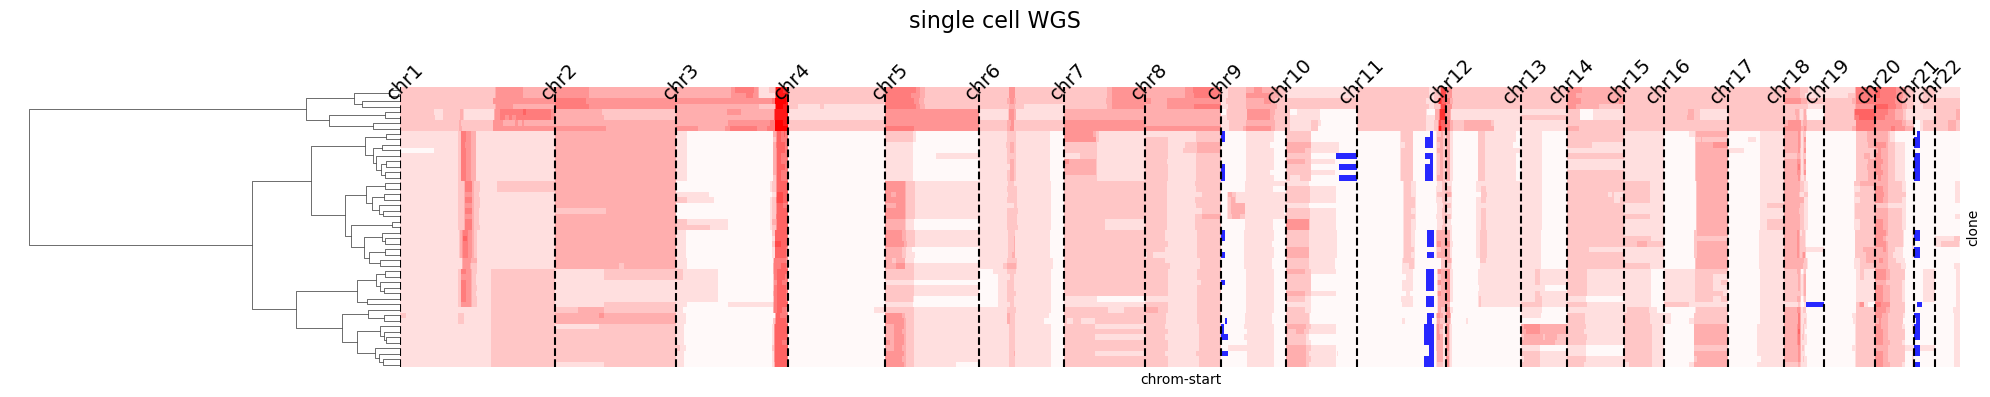

In [41]:
single_cell_clustermap = make_sample_heatmap(df=TRUE_copynumbers_plot_pivot,title='single cell WGS',figsize=(20,4),max_val=max_cn,segment=None,yticklabels=False,metric='euclidean')

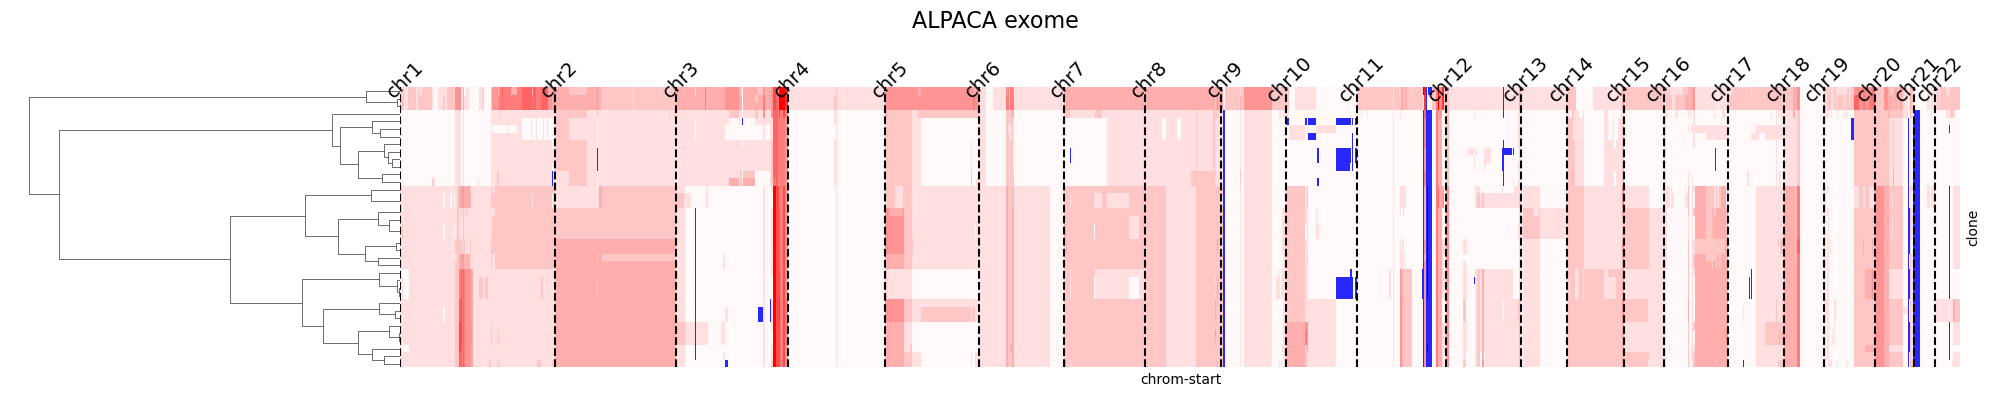

In [42]:
alpaca_clustermap = make_sample_heatmap(df=ALPACA_output_plot_pivot,title='ALPACA exome',figsize=(20,4),max_val=max_cn,segment=None,yticklabels=False,metric='euclidean')

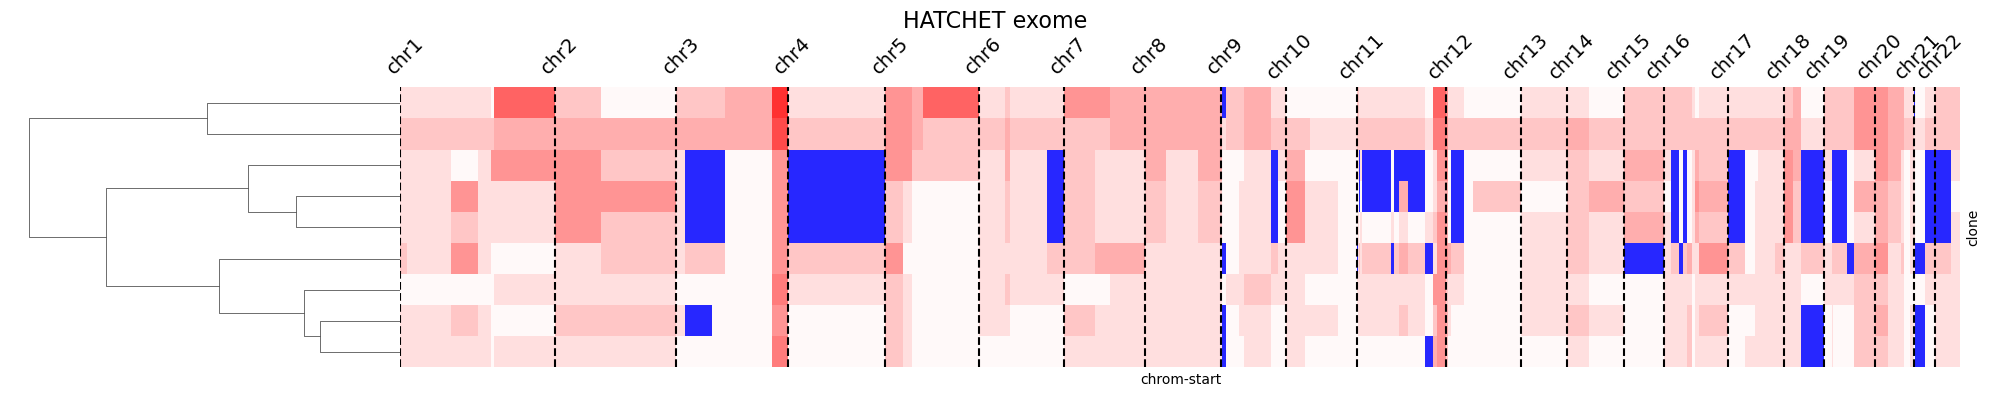

In [43]:
hatchet_clustermap = make_sample_heatmap(df=COMPARATOR_output_plot_pivot,title='HATCHET exome',figsize=(20,4),max_val=max_cn,segment=None,yticklabels=False,metric='euclidean')

In [ ]:
heatmap_dir = '../../figures'
hatchet_clustermap.savefig(f'{heatmap_dir}/Fig1f_clustermap_hatchet.pdf', bbox_inches='tight', format="pdf")
single_cell_clustermap.savefig(f'{heatmap_dir}/Fig1f_clustermap_single_cell.pdf', bbox_inches='tight', format="pdf")
alpaca_clustermap.savefig(f'{heatmap_dir}/Fig1f_clustermap_alpaca.pdf', bbox_inches='tight', format="pdf")

In [ ]:
#Figure 1: Single cell example case
fig_attr = {'font_size' : 15,
            'wgd_annotation_font_size' : 12,
            'pred_true_font_size' : 7,
            'chromosome_labels_font_size' : 7,
            'region_number_font_size' : 6,
            'colorbar_font_size' : 7,
            'annotation_font_size' : 11,
            'width_mm' : 260,
            'height_mm' : 66,
            'legend_y_offset':-0.4,
            'cbar_y_offset':-0.05,
            'bottom_margin':45,
            'clone_prop_annotation_legend_x':0.85,
            'clone_prop_annotation_legend_y':-0.34,
            'seg_solved_legend_x':1,
            'seg_solved_legend_y':-0.2,
            'incorrectly_legend_x':0.99,
            'incorrectly_legend_y':-0.3,
            'correctly_legend_x':1,
            'correctly_legend_y':-0.5,}

import SC_make_example_case_heatmaps
selected_tumours = ['S0noise0.1']
input_data_directory = f'{output_directory}/output/single_cell/single_cell_default'
cohort_results_file = f'{output_directory}/output/single_cell/single_cell_default/cohort_outputs/combined.csv'
chr_table_file = f'{output_directory}/_assets/chr_len.csv'
wgd_calls = f'{output_directory}/output/single_cell/single_cell_default/cohort_outputs/wgd_calls.csv'
wgd_calls = pd.read_csv(wgd_calls)
cohort_results = pd.read_csv(cohort_results_file)

for tumour_id in selected_tumours:
    tumour_input_directory = f'{input_data_directory}/patient_outputs'
    true = SC_make_example_case_heatmaps.true_unify_format(pd.read_csv(f'{tumour_input_directory}/copynumbers.csv'))
    tumour_wgd_calls = wgd_calls[wgd_calls.tumour_id == tumour_id]  
    wgd_clones = list(wgd_calls[wgd_calls.GD > 0].clones)
    alpaca_output = cohort_results[cohort_results.tumour_id==tumour_id]
    alpaca_output = alpaca_output[alpaca_output.clone.isin(['trunk', 'JII', 'JIII', 'JIV'])]
    heatmap_A = SC_make_example_case_heatmaps.plot_heatmap_with_tree_compare_with_true_solution_publication(alpaca_output=alpaca_output,input_data_directory=tumour_input_directory, chr_table_file=chr_table_file,wgd_clones=wgd_clones, max_cpn_cap=8, allele='A', true_solution_df=true, plot_comparison=True, sort_alleles=False,figure_attributes=fig_attr,clones_to_skip=['trunk'])
    heatmap_A.fig.write_image(f'{output_directory}/figures/Fig1g_single_cell_{tumour_id}_A_example_heatmap.pdf')
    heatmap_B = SC_make_example_case_heatmaps.plot_heatmap_with_tree_compare_with_true_solution_publication(alpaca_output=alpaca_output,input_data_directory=tumour_input_directory, chr_table_file=chr_table_file,wgd_clones=wgd_clones, max_cpn_cap=8, allele='B', true_solution_df=true, plot_comparison=True, sort_alleles=False,figure_attributes=fig_attr,clones_to_skip=['trunk'])
    heatmap_B.fig.write_image(f'{output_directory}/figures/Fig1g_single_cell_{tumour_id}_B_example_heatmap.pdf')

In [ ]:
#Figure 1: Single cell Sankey plot
from SC_sankey_plot import *
scores_all_tumours = pd.read_csv(f'{output_directory}/output/single_cell/single_cell_default/cohort_outputs/scores/scores_all_tumours.csv')[['clone','allele','segment','tumour_id','cn_true','cn_alpaca','correct']].drop_duplicates()
scores_all_tumours.cn_alpaca.clip(upper=5,inplace=True)
sankey = plotFlowDiagramSC(scores_all_tumours,'',hide_labels=True)
sankey.write_image(f'{output_directory}/figures/Fig1h_SC_sankey.pdf')
sankey

In [ ]:
# first submission figures
# Figure 1: matching comparison
#import MASCOTE_matching_comparison_boxplot
#scores_matched_comparison_all_tumours = f'{output_directory}/output/mascote/mascote_default/cohort_outputs/scores/scores_matched_comparison_all_tumours.csv'
#cohort_results = pd.read_csv(scores_matched_comparison_all_tumours)
#fig, w, h, scale, results = MASCOTE_matching_comparison_boxplot.make_matching_comparison_plot(cohort_results)
#fig.write_image(f'{output_directory}/figures/previous_Fig1b_matching_comparison_boxplot.pdf', width=w, height=h,scale=scale)
#results.to_csv(f'{output_directory}/figures/previous_Fig1b_matching_comparison_p_vals.csv', index=False)
#print(results)
#fig.show()

In [ ]:
# Figure 1: comparison with simple model
#import SIMULATIONS_compare_models_hist_prec_recall
#simulation_cohort = 'simulations'
#simulation_run = 'simulations_default'
#simple_run = 'simple_model_default'
#alpaca_scores = pd.read_csv(f'{output_directory}/output/{simulation_cohort}/{simulation_run}/cohort_outputs/scores/subclonal_scores_summary_ALPACA.csv')
#simple_scores = pd.read_csv(f'{output_directory}/output/{simulation_cohort}/{simple_run}/cohort_outputs/scores/subclonal_scores_summary_ALPACA.csv')
#fig = SIMULATIONS_compare_models_hist_prec_recall.make_comparison_histogram(alpaca_scores,simple_scores)
#fig.savefig(f'{output_directory}/figures/previous_Fig1c_histograms_alpaca_simple_comparison.png', bbox_inches='tight')
#fig.show()

In [ ]:
# Figure 1: barplot comparison
#import SIMULATIONS_barplot_comp_with_simple_model
#alpaca_scores_per_clone = pd.read_csv(f'{output_directory}/output/{simulation_cohort}/{simulation_run}/cohort_outputs/scores/all_scores_summary_ALPACA.csv')
#simple_scores_per_clone = pd.read_csv(f'{output_directory}/output/{simulation_cohort}/{simple_run}/cohort_outputs/scores/all_scores_summary_ALPACA.csv')
#fig = SIMULATIONS_barplot_comp_with_simple_model.make_barplot_comparison_plot_per_clone(alpaca_scores_per_clone,simple_scores_per_clone,font_size_points=4)
#fig.write_image(f'{output_directory}/figures/previous_Fig1d_barplot_alpaca_simple_comparison.pdf')
#fig.show()